# HVAE MOOD

### Loading MOOD Patches Model

* What doesn't seem to work:
    * Free nats = 2, 1 is fine for gaussian, 1 makes the logistic blow up
    * 100 mixtures doesn't seem to help it learn more, maybe 20 would be fine?
    * Good ELBO AUROC occurs when in gaussian with 1 nat and deterministic warmup. Maybe beta of < 1 is good for
    OOD detection?
    
Ideas
* 2.5D model, take 3D patches and randomly permute the axes of the patches during training to simulate looking at 
2D patches along all anatomical planes. A final score could be the average of those three or maybe even the
distance between those scores.
* KL term schedule, cycle up to a max and min every few epochs

Observations:
* Max in Sagittal: 7850 from validation set
* Max in axial: 7770 from validation set
* Max in coronal: 7646 --> coronal on OOD is much lower than the others (about 8996, others atleast 9000)
* It seems that taking the min as the highest healthy LLR does not bode well under the average_precision
metric. Driving the negatives down closest to zero as possible is not advantageous as you could miss important
near OOD examples. The score is naturally measured agnostic of the chosen threshold, similar to the AUROC score
* Combining sagittal, axial and coronal models seems to improve the pixel level results substaintially.
The most successful method of combining the scores has been through computing the joint probability of the three views by taking the product of the normalized scores.
* Decreasing the stride length doesn't seem to impact performance. Increasing does reduce it however
* BAD - pixel predictions are leaking into the background voxels which hurts performance. Quick fix is to
multiply by the mask of the bg to cancel out these predictions.
    * See if large bg_tol with above works better


Overarching Things to get done:
* What is actually going on with the choice of the output distribution? Is the choice of the MoL actually
provide some performance boost or is it simply overfitting?
* Dealing with generalization on datasets, can we tune our models on the different datasets and achieve similar
performance across the strata?
* Fix the striding algorithm, work for odd choices of image size and stride size
* Conditional dependence should work somehow. Need to grok the CVAEs better and combine some pertinent auxillary
input that could augment the performance


In [41]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import torch
import torchvision
import numpy as np
import nibabel as nib
from skimage import exposure

from sklearn.metrics import auc, roc_curve, average_precision_score, precision_recall_curve
from tqdm import tqdm, trange
from collections import defaultdict
from scipy.stats import multivariate_normal

import oodd
import oodd.models
import oodd.datasets
import oodd.losses
import oodd.evaluators
import oodd.utils
from oodd.layers.likelihoods import grayscale_log_continuous_mix_logistic


np.set_printoptions(suppress=True)
device = torch.device('cuda:1')

mood_brain_dir = '/data/mood/brain/brain_train'
mood_brain_mask_dir = '/data/mood/brain/toy_label/pixel'
mood_brain_toy_dir = '/data/mood/brain/toy'

mood_abdom_dir = '/data/mood/abdom/abdom_train'
mood_abdom_mask_dir = '/data/mood/abdom/toy_label/pixel'
mood_abdom_toy_dir = '/data/mood/abdom/toy'

DEFAULT_FONTSIZE = 13
sns.set_style('white')
mpl.rcParams.update({
    'font.size': DEFAULT_FONTSIZE,
    'lines.linewidth': 2,
    'legend.fontsize': DEFAULT_FONTSIZE,
    'axes.labelsize': DEFAULT_FONTSIZE,
    'xtick.labelsize': DEFAULT_FONTSIZE,
    'ytick.labelsize': DEFAULT_FONTSIZE,
    'figure.figsize': (7, 7.0 / 1.4),
})


ctx = sns.plotting_context('paper')

In [42]:
def make_strided_patches(img, patch_size=(28, 28), stride=(4, 4), tol=0.1, bg_tol=0.):
    """
    Returns a tuple of patches and coordinates given the a 2D slice of an image an optional 
    patch size and the stride length parameters.
    """
    # For our case of medical images, we discard images that are purely background
    if (img == 0).all():
        return None
    
    pipeline = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        oodd.datasets.transforms.PctileChauhan(0.05)
    ])

    def preprocess(arr, pipeline):
        arr = arr.astype('float32')
        return pipeline(arr)
    
    patches = []
    coords = []
    
    x_stride = stride[0]
    y_stride = stride[1]
    
    x_max = img.shape[0]
    y_max = img.shape[1]
    
    n_xstrides = (x_max - patch_size[0]) // x_stride
    n_ystrides = (y_max - patch_size[1]) // y_stride
    for x_stride_num in range(n_xstrides + 1):
        x_cur = x_stride_num * x_stride
        for y_stride_num in range(n_ystrides + 1):
            y_cur = y_stride_num * y_stride
            y2 = y_cur + patch_size[1]
            
            x2 = x_cur + patch_size[0]
            patch = img[x_cur : x2, y_cur: y2]
            if (patch <= bg_tol).sum() < int(patch_size[0] * patch_size[0] * tol):
                patches.append(preprocess(patch, pipeline))
                coords.append([x_cur, x2, y_cur, y2])
            
    if not patches:
        return None
    
    patches = torch.cat(patches).view(-1, 1, patch_size[0], patch_size[1])
    coords = torch.tensor(coords)
    return patches, coords

def image_generator(img_paths, tol=0):
    """Loads numpy arrays of images from disk"""
    for path in img_paths:
        img = nib.load(path)
        img_data = img.get_fdata()
        yield img_data, tol

In [43]:
mood_brain_paths = [os.path.join(mood_brain_dir, path) for path in os.listdir(mood_brain_dir)][502:600]

# Healthy
brain, _ = next(image_generator(mood_brain_paths))

toy_brain_paths = [os.path.join(mood_brain_toy_dir, path) for path in os.listdir(mood_brain_toy_dir)][:-1]
toy_gen = image_generator(toy_brain_paths)

# These three have spherical anomalies
toy_brain, _ = next(toy_gen)
#toy_brain, _ = next(toy_gen)
#toy_brain, _ = next(toy_gen)

In [44]:
toy_mask_paths = [os.path.join(mood_brain_mask_dir, path) for path in os.listdir(mood_brain_mask_dir)][:-1]
toy_mask_gen = image_generator(toy_mask_paths)
toy_mask, _ = next(toy_mask_gen)
#toy_mask, _ = next(toy_mask_gen)
#toy_mask, _ = next(toy_mask_gen)

In [45]:
mood_abdom_paths = [os.path.join(mood_abdom_dir, path) for path in os.listdir(mood_abdom_dir)][502:600]
abdom, _ = next(image_generator(mood_abdom_paths))

toy_abdom_paths = [os.path.join(mood_abdom_toy_dir, path) for path in os.listdir(mood_abdom_toy_dir)]#[:-1]
toy_gen = image_generator(toy_abdom_paths)
toy_abdom, _ = next(toy_gen)
toy_abdom, _ = next(toy_gen)
toy_abdom, _ = next(toy_gen)
toy_abdom, _ = next(toy_gen)

In [46]:
toy_abdom_mask_paths = [os.path.join(mood_abdom_mask_dir, path) for path in os.listdir(mood_abdom_mask_dir)][:-1]
toy_abdom_mask_gen = image_generator(toy_abdom_mask_paths)
toy_abdom_mask, _ = next(toy_abdom_mask_gen)
#toy_mask, _ = next(toy_mask_gen)
#toy_mask, _ = next(toy_mask_gen)

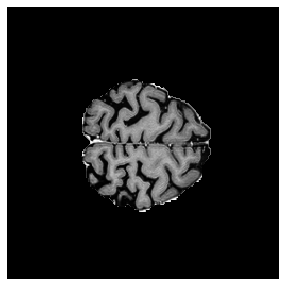

In [47]:
with sns.plotting_context('paper') as ctx:
    plt.imshow(brain[:, :, 180], cmap='gray')
    plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

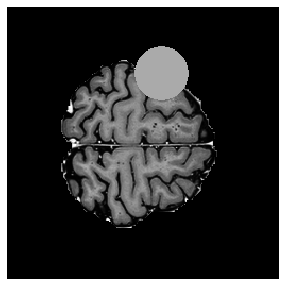

In [48]:
plt.imshow(toy_brain[:, :, 180], cmap='gray')
plt.axis('off')

In [50]:
checkpoint_axial = oodd.models.Checkpoint(path='./models/mood_10mix_1000epochs_no-cool_no-nats')
#checkpoint_abdom = oodd.models.Checkpoint(path='./models/mood_abdom_10-mix_500-epochs_no-nats_no-cooldown')
checkpoint_abdom = oodd.models.Checkpoint(path='./models/abdom_axial_small_latent')
checkpoint_sagittal = oodd.models.Checkpoint(path='./models/mood_brain_sagittal_10-mix_1000-epochs_no-cool_no-nats')
checkpoint_coronal = oodd.models.Checkpoint(path='./models/mood_brain_coronal_10-mix_1000-epochs_no-cool_no-nats')
checkpoint_gaussian = oodd.models.Checkpoint(path='./models/mood_brain_axial_gaussian_1000-epochs_1-nat_200-cooldown')
#checkpoint = oodd.models.Checkpoint(path='./models/mood_abdom_10-mix_150-epochs_no-nats_no-cooldown')

checkpoint_axial.load_model()
model_axial = checkpoint_axial.model
model_axial.eval()
model_axial.to(device)

checkpoint_sagittal.load_model()
model_sagittal = checkpoint_sagittal.model
model_sagittal.eval()
model_sagittal.to(device)

checkpoint_coronal.load_model()
model_coronal = checkpoint_coronal.model
model_coronal.eval()
model_coronal.to(device)

checkpoint_abdom.load_model()
model_abdom = checkpoint_abdom.model
model_abdom.eval()
model_abdom.to(device)

checkpoint_gaussian.load_model()
model_gaussian = checkpoint_gaussian.model
model_gaussian.eval()
model_gaussian.to(device)

models = {'axial': model_axial, 'sagittal': model_sagittal, 'coronal': model_coronal}
models_abdom = {'axial': model_abdom}
criterion = oodd.losses.ELBO()

In [51]:
stride_gen, coords = make_strided_patches(brain[:, :, 128])
dataset = torch.utils.data.TensorDataset(stride_gen, torch.tensor(coords))

<ipython-input-51-20977954063d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.utils.data.TensorDataset(stride_gen, torch.tensor(coords))


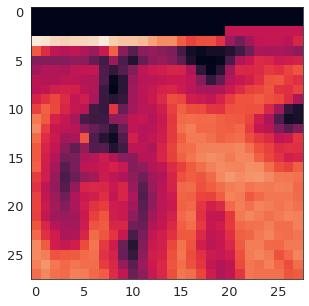

In [52]:
x1, x2, y1, y2 = coords[0]
plt.imshow(brain[:, :, 128][x1:x2, y1:y2])

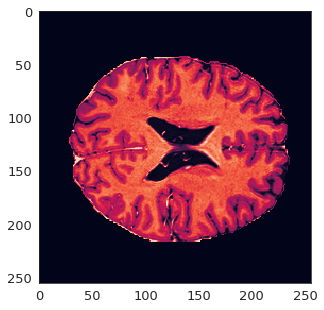

In [53]:
plt.imshow(brain[:, :, 128])

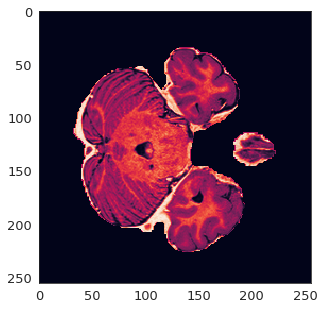

In [54]:
plt.imshow(toy_brain[:, :, 60])

In [58]:
# iw_samples_elbo = 1
# iw_samples_Lk = 1
# batch_size = 256
# n_latents_skip = 2
# n_eval_examples = float("inf")
# 
# SCORES = defaultdict(list)
# 
# def get_decode_from_p(n_latents, k=0, semantic_k=True):
#     """
#     k semantic out
#     0 True     [False, False, False]
#     1 True     [True, False, False]
#     2 True     [True, True, False]
#     0 False    [True, True, True]
#     1 False    [False, True, True]
#     2 False    [False, False, True]
#     """
#     if semantic_k:
#         return [True] * k + [False] * (n_latents - k)
# 
#     return [False] * (k + 1) + [True] * (n_latents - k - 1)
# 
# def get_lengths(dataloaders):
#     return [len(loader) for name, loader in dataloaders.items()]
# 
# voxel_scores = []
# means = []
# stride = (4, 4)
# tol = 0.05
# bg_tol = 0
# 
# img = toy_brain
# 
# for plane in models:
#     model = models[plane]
#     score_mask = np.full((256, 256, 256), 0., dtype='float32')
#     #score_mask = np.full((512, 512, 512), 0., dtype='float32')
#     #score_mask = np.full((256, 256, 256, 50), 0., dtype='float32')
#     #score_mask = np.empty((256, 256, 256, 50), dtype='object')
#     #for i, row in enumerate(score_mask):
#     #    for j, col in enumerate(row):
#     #        for z, width in enumerate(col):
#     #            score_mask[i, j, z] = []
#     #mean_mask = np.full((512, 512, 512), 0.)
#     mean_mask = np.full((256, 256, 256), 0.)
# 
#     for z in trange(img.shape[-1]):
#         if plane == 'axial':
#             strided_patches = make_strided_patches(img[:, :, z], stride=stride, tol=tol, bg_tol=bg_tol)
#         elif plane == 'sagittal':
#             strided_patches = make_strided_patches(img[z, :, :], stride=stride, tol=tol, bg_tol=bg_tol)
#         elif plane == 'coronal':
#             strided_patches = make_strided_patches(img[:, z, :], stride=stride, tol=tol, bg_tol=bg_tol)
#         if strided_patches:
#             stride_gen, coords = strided_patches 
#         else:
#             continue
#         dataset = torch.utils.data.TensorDataset(stride_gen, coords)
#         loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
# 
#         #n_test_batches = get_lengths(datamodule.val_datasets) + get_lengths(datamodule.test_datasets)
#         #N_EQUAL_EXAMPLES_CAP = min(n_test_batches)
#         #assert N_EQUAL_EXAMPLES_CAP % batch_size == 0, "Batch size must divide smallest dataset size"
#         #N_EQUAL_EXAMPLES_CAP = min([n_eval_examples, N_EQUAL_EXAMPLES_CAP])
# 
#         decode_from_p = get_decode_from_p(model.n_latents, k=n_latents_skip)
# 
#         scores = defaultdict(list)
#         elbos = defaultdict(list)
#         elbos_k = defaultdict(list)
#         with torch.no_grad():
#             n = 0
#             for b, (x, coord) in enumerate(loader):
#                 x = x.to(device)
#                 n += x.shape[0]
#                 sample_elbos, sample_elbos_k = [], []
# 
#                 # Regular ELBO
#                 for i in range(iw_samples_elbo):
#                     likelihood_data, stage_datas = model(x, decode_from_p=False, use_mode=False)
#                     kl_divergences = [
#                         stage_data.loss.kl_elementwise
#                         for stage_data in stage_datas
#                         if stage_data.loss.kl_elementwise is not None
#                     ]
#                     loss, elbo, likelihood, kl_divergences = criterion(
#                         likelihood_data.likelihood,
#                         kl_divergences,
#                         samples=1,
#                         free_nats=0,
#                         beta=1,
#                         sample_reduction=None,
#                         batch_reduction=None,
#                     )
#                     sample_elbos.append(elbo.detach())
# 
#                 # L>k bound
#                 for i in range(iw_samples_Lk):
#                     likelihood_data_k, stage_datas_k = model(x, decode_from_p=decode_from_p, use_mode=decode_from_p)
#                     kl_divergences_k = [
#                         stage_data.loss.kl_elementwise
#                         for stage_data in stage_datas_k
#                         if stage_data.loss.kl_elementwise is not None
#                     ]
#                     loss_k, elbo_k, likelihood_k, kl_divergences_k = criterion(
#                         likelihood_data_k.likelihood,
#                         kl_divergences_k,
#                         samples=1,
#                         free_nats=0,
#                         beta=1,
#                         sample_reduction=None,
#                         batch_reduction=None,
#                     )
#                     sample_elbos_k.append(elbo_k.detach())
# 
#                 sample_elbos = torch.stack(sample_elbos, axis=0)
#                 sample_elbos_k = torch.stack(sample_elbos_k, axis=0)
# 
#                 sample_elbo = oodd.utils.log_sum_exp(sample_elbos, axis=0)
#                 sample_elbo_k = oodd.utils.log_sum_exp(sample_elbos_k, axis=0)
# 
#                 score = sample_elbo - sample_elbo_k
# 
#                 for ind, (x1, x2, y1, y2) in enumerate(coord):
#                     if plane == 'axial':
#                         score_mask[x1:x2, y1:y2, z] += score[ind].detach().cpu().numpy()
#                         mean_mask[x1:x2, y1:y2, z] += 1
#                     elif plane == 'sagittal':
#                         score_mask[z, x1:x2, y1:y2] += score[ind].detach().cpu().numpy()
#                         mean_mask[z, x1:x2, y1:y2] += 1
#                     elif plane == 'coronal':
#                         score_mask[x1:x2, z, y1:y2] += score[ind].detach().cpu().numpy()
#                         mean_mask[x1:x2, z, y1:y2] += 1
# 
#                     #score_mask[x1:x2, y1:y2] += weight_mask * score[ind].detach().cpu().numpy()
#                     #mean_mask[x1:x2, y1:y2] += weight_mask
# 
#                     #patch_score = score[ind].detach().cpu().numpy()
#                     #score_slice = score_mask[x1:x2, y1:y2, z]
# 
#                     #for row in pixel_lists:
#                     #    for col in row:
#                     #        col.append(patch_score)
#                     #score_slice[np.nonzero(pixel_lists)] = patch_score
#                     #score_slice[:, :, np.argmax(score_slice == 0, axis=-1)] = patch_score
# 
#                 scores[name].extend(score.tolist())
#                 elbos[name].extend(sample_elbo.tolist())
#                 elbos_k[name].extend(sample_elbo_k.tolist())
# 
#         SCORES[brain_name].extend(scores[brain_name])
#     means.append(mean_mask)
#     voxel_scores.append(score_mask)

In [59]:
iw_samples_elbo = 1
iw_samples_Lk = 1
batch_size = 256
n_latents_skip = 2
n_eval_examples = float("inf")

brain_name = 'brain'

SCORES = defaultdict(list)
COMP_SCORES = defaultdict(list)

def get_decode_from_p(n_latents, k=0, semantic_k=True):
    """
    k semantic out
    0 True     [False, False, False]
    1 True     [True, False, False]
    2 True     [True, True, False]
    0 False    [True, True, True]
    1 False    [False, True, True]
    2 False    [False, False, True]
    """
    if semantic_k:
        return [True] * k + [False] * (n_latents - k)

    return [False] * (k + 1) + [True] * (n_latents - k - 1)

def get_lengths(dataloaders):
    return [len(loader) for name, loader in dataloaders.items()]

voxel_scores_healthy = []
means_healthy = []
stride = (4, 4)
tol = 0.05
bg_tol = 0

for plane in models:
    model = models[plane]
    score_mask = np.full((256, 256, 256), 0., dtype='float32')
    #score_mask = np.full((512, 512, 512), 0., dtype='float32')
    #score_mask = np.full((256, 256, 256, 50), 0., dtype='float32')
    #score_mask = np.empty((256, 256, 256, 50), dtype='object')
    #for i, row in enumerate(score_mask):
    #    for j, col in enumerate(row):
    #        for z, width in enumerate(col):
    #            score_mask[i, j, z] = []
    #mean_mask = np.full((512, 512, 512), 0.)
    mean_mask = np.full((256, 256, 256), 0.)
    
    for z in trange(brain.shape[-1]):
        if plane == 'axial':
            strided_patches = make_strided_patches(brain[:, :, z], stride=stride, tol=tol, bg_tol=bg_tol)
        elif plane == 'sagittal':
            strided_patches = make_strided_patches(brain[z, :, :], stride=stride, tol=tol, bg_tol=bg_tol)
        elif plane == 'coronal':
            strided_patches = make_strided_patches(brain[:, z, :], stride=stride, tol=tol, bg_tol=bg_tol)
        if strided_patches:
            stride_gen, coords = strided_patches 
        else:
            continue
        dataset = torch.utils.data.TensorDataset(stride_gen, coords)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

        decode_from_p = get_decode_from_p(model.n_latents, k=n_latents_skip)
        comp_decode_from_p = get_decode_from_p(model.n_latents, k=1, semantic_k=False)

        scores = defaultdict(list)
        elbos = defaultdict(list)
        elbos_k = defaultdict(list)
        elbos_l = defaultdict(list)
        gen_llr_scores = defaultdict(list)
        with torch.no_grad():
            n = 0
            for b, (x, coord) in enumerate(loader):
                x = x.to(device)
                n += x.shape[0]
                sample_elbos, sample_elbos_k, sample_elbos_l = [], [], []

                # Regular ELBO
                for i in range(iw_samples_elbo):
                    likelihood_data, stage_datas = model(x, decode_from_p=False, use_mode=False)
                    kl_divergences = [
                        stage_data.loss.kl_elementwise
                        for stage_data in stage_datas
                        if stage_data.loss.kl_elementwise is not None
                    ]
                    loss, elbo, likelihood, kl_divergences = criterion(
                        likelihood_data.likelihood,
                        kl_divergences,
                        samples=1,
                        free_nats=0,
                        beta=1,
                        sample_reduction=None,
                        batch_reduction=None,
                    )
                    sample_elbos.append(elbo.detach())

                # L>k bound
                for i in range(iw_samples_Lk):
                    likelihood_data_k, stage_datas_k = model(x, decode_from_p=decode_from_p, use_mode=decode_from_p)
                    kl_divergences_k = [
                        stage_data.loss.kl_elementwise
                        for stage_data in stage_datas_k
                        if stage_data.loss.kl_elementwise is not None
                    ]
                    loss_k, elbo_k, likelihood_k, kl_divergences_k = criterion(
                        likelihood_data_k.likelihood,
                        kl_divergences_k,
                        samples=1,
                        free_nats=0,
                        beta=1,
                        sample_reduction=None,
                        batch_reduction=None,
                    )
                    sample_elbos_k.append(elbo_k.detach())
                    
                # L>l bound
                for i in range(iw_samples_Lk):
                    likelihood_data_l, stage_datas_l = model(x, decode_from_p=comp_decode_from_p, use_mode=comp_decode_from_p)
                    kl_divergences_l = [
                        stage_data.loss.kl_elementwise
                        for stage_data in stage_datas_l
                        if stage_data.loss.kl_elementwise is not None
                    ]
                    loss_l, elbo_l, likelihood_l, kl_divergences_l = criterion(
                        likelihood_data_l.likelihood,
                        kl_divergences_l,
                        samples=1,
                        free_nats=0,
                        beta=1,
                        sample_reduction=None,
                        batch_reduction=None,
                    )
                    sample_elbos_l.append(elbo_k.detach())

                sample_elbos = torch.stack(sample_elbos, axis=0)
                sample_elbos_k = torch.stack(sample_elbos_k, axis=0)
                sample_elbos_l = torch.stack(sample_elbos_l, axis=0)

                sample_elbo = oodd.utils.log_sum_exp(sample_elbos, axis=0)
                sample_elbo_k = oodd.utils.log_sum_exp(sample_elbos_k, axis=0)
                sample_elbo_l = oodd.utils.log_sum_exp(sample_elbos_l, axis=0)

                score = sample_elbo - sample_elbo_k
                gen_llr_score = sample_elbo_l - sample_elbo_k

                for ind, (x1, x2, y1, y2) in enumerate(coord):
                    if plane == 'axial':
                        score_mask[x1:x2, y1:y2, z] += score[ind].detach().cpu().numpy()
                        mean_mask[x1:x2, y1:y2, z] += 1
                    elif plane == 'sagittal':
                        score_mask[z, x1:x2, y1:y2] += score[ind].detach().cpu().numpy()
                        mean_mask[z, x1:x2, y1:y2] += 1
                    elif plane == 'coronal':
                        score_mask[x1:x2, z, y1:y2] += score[ind].detach().cpu().numpy()
                        mean_mask[x1:x2, z, y1:y2] += 1

                    #score_mask[x1:x2, y1:y2] += weight_mask * score[ind].detach().cpu().numpy()
                    #mean_mask[x1:x2, y1:y2] += weight_mask

                    #patch_score = score[ind].detach().cpu().numpy()
                    #score_slice = score_mask[x1:x2, y1:y2, z]

                    #for row in pixel_lists:
                    #    for col in row:
                    #        col.append(patch_score)
                    #score_slice[np.nonzero(pixel_lists)] = patch_score
                    #score_slice[:, :, np.argmax(score_slice == 0, axis=-1)] = patch_score

                scores[brain_name].extend(score.tolist())
                elbos[brain_name].extend(sample_elbo.tolist())
                elbos_k[brain_name].extend(sample_elbo_k.tolist())
                elbos_l[brain_name].extend(sample_elbo_l.tolist())
                gen_llr_scores[brain_name].extend(gen_llr_score.tolist())

        SCORES[brain_name].extend(scores[brain_name])
        COMP_SCORES[brain_name].extend(gen_llr_scores[brain_name])
        
    means_healthy.append(mean_mask)
    voxel_scores_healthy.append(score_mask)


100%|██████████| 256/256 [01:35<00:00,  2.68it/s]


In [ ]:
COMP_SCORES

In [ ]:
elbos_l

In [ ]:
elbos_k

In [ ]:
mood_brain_paths = [os.path.join(mood_brain_dir, path) for path in os.listdir(mood_brain_dir)][502:600]
brain, _ = next(image_generator(mood_brain_paths))

toy_brain_paths = [os.path.join(mood_brain_toy_dir, path) for path in os.listdir(mood_brain_toy_dir)]
toy_brains = [img.ravel() for img, _ in list(image_generator(toy_brain_paths))]
#toy_brain, _ = next(toy_gen)
#toy_brain, _ = next(toy_gen)

In [ ]:
#toy_results_path = '/home/derek/toy_results/6000_thres_brain_three_planes'
toy_results_path = '/home/derek/toy_results/mood_2022_submission_results'
brain_toy_results = [os.path.join(toy_results_path, 'brain', path) for path in os.listdir('/home/derek/toy_results/6000_thres_brain_three_planes/brain')][1:]
abdom_toy_results = [os.path.join(toy_results_path, 'abdom', path) for path in os.listdir('/home/derek/toy_results/6000_thres_brain_three_planes/abdom')][1:]

brain_toy_results = [img.ravel() for img, _ in list(image_generator(brain_toy_results))]
abdom_toy_results = [img.ravel() for img, _ in list(image_generator(abdom_toy_results, tol=0))]

In [ ]:
toy_mask_paths = [os.path.join(mood_brain_mask_dir, path) for path in os.listdir(mood_brain_mask_dir)]
toy_brain_masks = [mask.ravel() for mask, _ in list(image_generator(toy_mask_paths))]

In [ ]:
toy_abdom_mask_paths = [os.path.join(mood_abdom_mask_dir, path) for path in os.listdir(mood_abdom_mask_dir)]
toy_abdom_masks = [mask.ravel() for mask, _ in list(image_generator(toy_abdom_mask_paths))]

In [ ]:
y_true = np.hstack(toy_brain_masks)
y_score = np.hstack(brain_toy_results) #* (np.hstack(toy_brains) != 0)

prec, recall, _ = precision_recall_curve(y_true, y_score)
average_precision = average_precision_score(y_true, y_score)
PrecisionRecallDisplay(precision=prec, recall=recall, average_precision=average_precision, estimator_name='Axial Brain HVAE').plot()

In [ ]:
y_true = np.hstack(toy_abdom_masks)
y_score = np.hstack(abdom_toy_results)

prec, recall, _ = precision_recall_curve(y_true, y_score)
average_precision = average_precision_score(y_true, y_score)
PrecisionRecallDisplay(precision=prec, recall=recall, average_precision=average_precision, estimator_name='Axial Abdom HVAE').plot(color='orange')

In [ ]:
y_true = np.hstack(toy_brain_masks)
y_score = np.hstack(brain_toy_results)

prec, recall, _ = precision_recall_curve(y_true, y_score)
average_precision = average_precision_score(y_true, y_score)
PrecisionRecallDisplay(precision=prec, recall=recall, average_precision=average_precision, estimator_name='3-Plane Brain HVAE').plot()

In [ ]:
y_true = np.hstack(toy_abdom_masks)
y_score = np.hstack(abdom_toy_results)

prec, recall, _ = precision_recall_curve(y_true, y_score)
average_precision = average_precision_score(y_true, y_score)
PrecisionRecallDisplay(precision=prec, recall=recall, average_precision=average_precision, estimator_name='Axial Abdom HVAE').plot(color='orange')

In [ ]:
fig, axes = plt.subplots(1, 3)

for i, ax in enumerate(axes):
    ax.imshow(voxel_scores[i][:, :, 71])

In [ ]:
plt.imshow(toy_brain[:, :,  180])

In [ ]:
score_mask = voxel_scores[0] + voxel_scores[1] + voxel_scores[2]
mean_mask = means[0] + means[1] + means[2]

#score_mask = np.maximum(np.maximum(voxel_scores[0], voxel_scores[1]), voxel_scores[2])
#mean_mask = np.where(voxel_scores[0] > voxel_scores[1], means[0], means[1])
#mean_mask = np.where(mean_mask > means[2], mean_mask, means[2])

#score_mask = np.minimum(np.minimum(voxel_scores[0], voxel_scores[1]), voxel_scores[2])
#mean_mask = np.where(voxel_scores[0] < voxel_scores[1], means[0], means[1])
#mean_mask = np.where(mean_mask < means[2], mean_mask, means[2])

plt.imshow(score_mask[:, :, 128])

In [ ]:
def min_max_normalization(x, low=0, high=1, axis=None):
    return low * (x > 0) + (x - (x < 0) * np.min(x, axis=axis)) * (high - low) / (np.max(x, axis=axis) - np.min(x, axis=axis))

In [ ]:
norm_min = np.min([np.min(arr[arr > 0]) for arr in voxel_scores])
norm_max = np.min([np.max(arr) for arr in voxel_scores])

voxel_scores_normed = [min_max_normalization(arr, low=norm_min, high=norm_max) for arr in voxel_scores]
score_mask_normed = voxel_scores_normed[0] + voxel_scores_normed[1] + voxel_scores_normed[2]

In [ ]:
template = np.full((256, 256, 256), 0., dtype='float32')
with tqdm(total=256) as pbar:
    for i, row in enumerate(score_mask):
        for j, col in enumerate(row):
            for z, width in enumerate(col):
                if not width:
                    continue
                agg_score = np.array(width)
                half = np.percentile(agg_score, 50)
                template[i, j, z] = np.mean(agg_score[agg_score <= half])
        pbar.update(1)

In [ ]:
normalized = np.maximum(0, score_mask - np.percentile(score_mask, 90))
normalized = (normalized / np.max(normalized)) #+ (toy_mask == False)[:, :, 140] 
plt.imshow(normalized, cmap='gray')
plt.colorbar()

In [ ]:
plt.imshow(score_mask *(toy_mask == False)[:, :, 140], cmap='gray')
plt.colorbar()

In [ ]:
plt.imshow(score_mask * (toy_brain[:, :, 140] == 0))
plt.colorbar()

In [ ]:
plt.imshow(score_mask, cmap='gray')
plt.colorbar()

In [ ]:
plt.imshow(mean_mask)
plt.colorbar()

In [ ]:
per_pixel_map = score_mask / mean_mask
per_pixel_map = np.where(np.isnan(per_pixel_map), 0, per_pixel_map)
min_llr = np.min(per_pixel_map[per_pixel_map > 0])
max_llr = 7700
new_normed = np.where(per_pixel_map > 0, (per_pixel_map - min_llr) / max_llr, score_mask)
plt.imshow(new_normed[:, :, 60])
#plt.imshow(per_pixel_map[:, :, 50], cmap='gray')
plt.colorbar()

In [ ]:
np.max(SCORES['brain'], axis=0)

In [ ]:
healthy_averaged_scores

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [ ]:
healthy_averaged_scores = np.hstack([np.where(np.isnan(p / mean), 0, p).ravel().reshape(-1, 1) for p, mean in zip(voxel_scores_healthy, means_healthy)])
#iso_forest = IsolationForest(behaviour='new')
#iso_forest.fit(healthy_averaged_scores[healthy_averaged_scores.sum(axis=1) != 0])

one_c_svm = OneClassSVM()
one_c_svm.fit(healthy_averaged_scores[healthy_averaged_scores.sum(axis=1) != 0])

In [ ]:
anomalous_averaged_scores = np.hstack([np.where(np.isnan(p / mean), 0, p).ravel().reshape(-1, 1) for p, mean in zip(voxel_scores, means)])
anom_score = iso_forest.score_samples(anomalous_averaged_scores)

In [ ]:
plt.hist(anom_score[(brain != 0).ravel()], bins=100)

In [ ]:
# No bg
no_bg_anom_score = (-anom_score.reshape(256, 256, 256) * (toy_brain != 0))
print(f"Combined scores AP: {average_precision_score(toy_mask.ravel().astype(int), -no_bg_anom_score.ravel())}")

In [ ]:
plt.imshow([:, :, 180])
plt.colorbar()

In [ ]:
per_pixel_map = score_mask / mean_mask
per_pixel_map = np.where(np.isnan(per_pixel_map), 0, per_pixel_map)
#plt.imshow(per_pixel_map[:, :, 140], cmap='gray')
normalized = np.clip(per_pixel_map - 7800, 0, np.inf)
norm_factor = np.max(normalized)
if norm_factor == 0:
    pass
else:
    normalized /= np.max(normalized)
plt.imshow(normalized[:, :, 70], cmap='gray')
plt.colorbar()

In [ ]:
plt.imshow(toy_brain[:, :, 128], cmap='gray')
plt.colorbar()

In [ ]:
#per_pixel_map_axial = score_mask / mean_mask
#per_pixel_map_axial = score_mask_normed / mean_mask
per_pixel_map_axial = voxel_scores[0] / means[0]
per_pixel_map_axial = np.where(np.isnan(per_pixel_map_axial), 0, per_pixel_map_axial)
#plt.imshow(per_pixel_map_axial[:, :, 140], cmap='gray')
#normalized = np.clip(per_pixel_map_axial - 7800, 0, np.inf)
mn = 6000
mx = 7850

#mn = 0
#mx = 20000
normalized_axial = np.where(per_pixel_map_axial < mn, 0, per_pixel_map_axial)
normalized_axial = np.where(per_pixel_map_axial > mx, 1, normalized_axial)
normalized_axial = np.where((per_pixel_map_axial <= mx) & (per_pixel_map_axial >= mn), (per_pixel_map_axial-mn)/(mx-mn), normalized_axial)
#factor = 8000 - 7800
plt.imshow(normalized_axial[:, :, 180], cmap='gray')
plt.title('Axial Brain Rescaled LLR Score')
plt.colorbar()
plt.axis('off')

In [ ]:
#per_pixel_map_sagittal = score_mask / mean_mask
#per_pixel_map_sagittal = score_mask_normed / mean_mask
per_pixel_map_sagittal = voxel_scores[1] / means[1]
per_pixel_map_sagittal = np.where(np.isnan(per_pixel_map_sagittal), 0, per_pixel_map_sagittal)
#plt.imshow(per_pixel_map_sagittal[:, :, 140], cmap='gray')
#normalized_sagittal = np.clip(per_pixel_map_sagittal - 7800, 0, np.inf)
#mn = 7000
mn = 6000
mx = 7950

#mn = 0
#mx = 20000
normalized_sagittal = np.where(per_pixel_map_sagittal < mn, 0, per_pixel_map_sagittal)
normalized_sagittal = np.where(per_pixel_map_sagittal > mx, 1, normalized_sagittal)
normalized_sagittal = np.where((per_pixel_map_sagittal <= mx) & (per_pixel_map_sagittal >= mn), (per_pixel_map_sagittal-mn)/(mx-mn), normalized_sagittal)
#factor = 8000 - 7800
plt.imshow(normalized_sagittal[:, :, 180], cmap='gray')
plt.title('Sagittal Brain Rescaled LLR Score')
plt.colorbar()
plt.axis('off')

In [ ]:
#per_pixel_map_coronal = score_mask / mean_mask
#per_pixel_map_coronal = score_mask_normed / mean_mask
per_pixel_map_coronal = voxel_scores[2] / means[2]
per_pixel_map_coronal = np.where(np.isnan(per_pixel_map_coronal), 0, per_pixel_map_coronal)
#plt.imshow(per_pixel_map_coronal[:, :, 140], cmap='gray')
#normalized_coronal = np.clip(per_pixel_map_coronal - 7800, 0, np.inf)
mn = 6000
mx = 7750

#mn = 0
#mx = 20000
normalized_coronal = np.where(per_pixel_map_coronal < mn, 0, per_pixel_map_coronal)
normalized_coronal = np.where(per_pixel_map_coronal > mx, 1, normalized_coronal)
normalized_coronal = np.where((per_pixel_map_coronal <= mx) & (per_pixel_map_coronal >= mn), (per_pixel_map_coronal-mn)/(mx-mn), normalized_coronal)
#factor = 8000 - 7800
plt.imshow(normalized_coronal[:, :, 180], cmap='gray')
plt.title('Coronal Brain Rescaled LLR Score')
plt.colorbar()
plt.axis('off')

In [ ]:
per_pixel_map_corona

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
IsolationForest()

In [ ]:
bg_mask = (toy_brain != 0)
#comb_normalized = np.maximum(np.maximum(normalized_axial, normalized_sagittal), normalized_coronal) * (toy_brain != 0)

# The product of their probabilities
#comb_normalized = (normalized_axial * normalized_sagittal * normalized_coronal) * (toy_brain != 0)


#comb_normalized = np.where(normalized_axial > 0, normalized_axial * normalized_sagittal, normalized_sagittal)
#comb_normalized = np.where(comb_normalized > 0, comb_normalized * normalized_coronal, normalized_coronal)

element_wise_max = np.maximum(np.maximum(normalized_axial, normalized_sagittal), normalized_coronal)
element_wise_min = np.minimum(np.minimum(normalized_axial, normalized_sagittal), normalized_coronal)
element_wise_range = np.abs(element_wise_max - element_wise_min)

#comb_normalized = np.where(
    #element_wise_range <= 0.3, normalized_axial * normalized_sagittal * normalized_coronal, element_wise_max)
#comb_normalized = element_wise_max
comb_normalized = np.mean([normalized_axial, normalized_sagittal, normalized_coronal], axis=0)

#comb_normalized = np.where(
    #element_wise_range <= 0.9, (normalized_axial + normalized_sagittal + normalized_coronal) / 3, element_wise_max) * (toy_brain != 0)

#comb_normalized = np.where(np.abs(comb_normalized - normalized_coronal) <= 0.5, comb_normalized * normalized_coronal, np.maximum(normalized_coronal, comb_normalized))
plt.imshow(comb_normalized[:, :, 180], cmap='gray')
plt.title('Combined Brain Score')
plt.colorbar()
plt.axis('off')

In [ ]:
print(f"Combined scores AP: {average_precision_score(toy_mask.ravel().astype(int), comb_normalized.ravel())}")
print(f"Axial scores AP: {average_precision_score(toy_mask.ravel().astype(int), normalized_axial.ravel())}")
print(f"Sagittal scores AP: {average_precision_score(toy_mask.ravel().astype(int), normalized_sagittal.ravel())}")
print(f"Coronal scores AP: {average_precision_score(toy_mask.ravel().astype(int), normalized_coronal.ravel())}")

In [ ]:
average_precision_score([1., 1., 1., 0., 0., 0.], [0.1, 0.1, 0.1, 0.2, 0.0, 0.0])

In [ ]:
plt.imshow(score_mask *(toy_mask == False)[:, :, 140], cmap='gray')
plt.colorbar()

In [ ]:
plt.imshow(per_pixel_map * (toy_brain[:, :, 140] == 0))
plt.colorbar()

In [ ]:
plt.hist(SCORES['brain'], bins=100, color='orange')
plt.title('toy_2 LLRs')

In [ ]:
plt.hist(SCORES['brain'], bins=100, color='orange')
plt.title('Healthy Abdom LLRs')

### Toy Validation Set Results

In [ ]:
datamodule = oodd.datasets.DataModule(
        batch_size=128,
        test_batch_size=500,
        data_workers=4,
        train_datasets= {
            "MOODPatchesPctileChauhan": {"dset_path": "/home/derek/mood_patches/brain_patches28_with_val.npz", "split": "train"
        }},
        val_datasets={
            "MOODPatchesPctileChauhan": {"dset_path": "/home/derek/mood_patches/brain_patches28_with_val.npz", "split": "validation", "toy": False},
            #"MOODPatchesPctileChauhan": {"split": "validation", "toy": 'true'},
            "MOODPatchesPctileChauhan-1": {"dset_path": "/home/derek/mood_patches/brain_toy_patches_only_anom.npz", "split": "validation", "toy": False, "anom": True},
            #"MOODPatchesRaw": {"dset_path": "/home/derek/mood_patches/brain_patches28_with_val.npz", "split": "validation", "toy": False},
            #"MOODPatchesRaw-1": {"dset_path": "/home/derek/mood_patches/brain_toy_patches_only_anom.npz", "split": "validation", "toy": False, "anom": True},
            "MNISTPctile" : {"split": "validation", "dynamic": False},
            "FashionMNISTPctile" : {"split": "validation", "dynamic": False}
        },
        test_datasets={
            #"MOODPatchesRaw": {"split": "validation", "toy": False, "anom": True}
        },
)

checkpoint_raw = oodd.models.Checkpoint(path='./models/MOODPatchesRaw-2022-09-20-21-36-25.194489')
#checkpoint = oodd.models.Checkpoint(path='./models/mood_abdom_10-mix_150-epochs_no-nats_no-cooldown')

checkpoint_raw.load_model()
model_raw = checkpoint_raw.model
model_raw.eval()
model_raw.to(device)

dataloaders = {(k + " test", v) for k, v in datamodule.val_loaders.items()}

In [ ]:
plt.imshow(datamodule.val_datasets['MOODPatchesRaw'][0][0].squeeze(), cmap='gray')

In [ ]:
plt.imshow(datamodule.val_datasets['MOODPatchesPctileChauhan'][0][0].squeeze(), cmap='gray')

In [ ]:
normalized = datamodule.val_datasets['MOODPatchesPctileChauhan']
normalized_sample = [normalized[i][0] for i in range(4)]
fig, axes = plt.subplots(2, 2)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(normalized_sample[i].squeeze(), cmap='gray')
    ax.axis('off')
fig.tight_layout()

In [ ]:
raw = datamodule.val_datasets['MOODPatchesRaw']
raw_sample = [raw[i][0] for i in range(4)]
fig, axes = plt.subplots(2, 2)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(raw_sample[i].squeeze(), cmap='gray')
    ax.axis('off')
fig.tight_layout()

In [ ]:
iw_samples_elbo = 1
iw_samples_Lk = 1
batch_size = 500
n_latents_skip = 2
n_eval_examples = float("inf")
criterion = oodd.losses.ELBO()

def get_decode_from_p(n_latents, k=0, semantic_k=True):
    """
    k semantic out
    0 True     [False, False, False]
    1 True     [True, False, False]
    2 True     [True, True, False]
    0 False    [True, True, True]
    1 False    [False, True, True]
    2 False    [False, False, True]
    """
    if semantic_k:
        return [True] * k + [False] * (n_latents - k)

    return [False] * (k + 1) + [True] * (n_latents - k - 1)

def get_lengths(dataloaders):
    return [len(loader) for name, loader in dataloaders.items()]

n_test_batches = get_lengths(datamodule.val_datasets) + get_lengths(datamodule.test_datasets)
N_EQUAL_EXAMPLES_CAP = min(n_test_batches)
assert N_EQUAL_EXAMPLES_CAP % batch_size == 0, "Batch size must divide smallest dataset size"
N_EQUAL_EXAMPLES_CAP = min([n_eval_examples, N_EQUAL_EXAMPLES_CAP])

decode_from_p = get_decode_from_p(model_axial.n_latents, k=n_latents_skip)

scores = defaultdict(list)
elbos = defaultdict(list)
elbos_k = defaultdict(list)
with torch.no_grad():
    for dataset, dataloader in dataloaders:
        dataset = dataset.replace("Binarized", "").replace("Quantized", "").replace("Dequantized", "")
        #print(f"Evaluating {dataset}")

        n = 0
        for b, (x, _) in tqdm(enumerate(dataloader), total=N_EQUAL_EXAMPLES_CAP / batch_size, leave=True, position=0):
            x = x.to(device)

            n += x.shape[0]
            sample_elbos, sample_elbos_k = [], []

            # Regular ELBO
            for i in tqdm(range(iw_samples_elbo), leave=True):
                likelihood_data, stage_datas = model_axial(x, decode_from_p=False, use_mode=False)
                kl_divergences = [
                    stage_data.loss.kl_elementwise
                    for stage_data in stage_datas
                    if stage_data.loss.kl_elementwise is not None
                ]
                loss, elbo, likelihood, kl_divergences = criterion(
                    likelihood_data.likelihood,
                    kl_divergences,
                    samples=1,
                    free_nats=0,
                    beta=1,
                    sample_reduction=None,
                    batch_reduction=None,
                )
                sample_elbos.append(elbo.detach())

            # L>k bound
            for i in tqdm(range(iw_samples_Lk), leave=True):
                likelihood_data_k, stage_datas_k = model_axial(x, decode_from_p=decode_from_p, use_mode=decode_from_p)
                kl_divergences_k = [
                    stage_data.loss.kl_elementwise
                    for stage_data in stage_datas_k
                    if stage_data.loss.kl_elementwise is not None
                ]
                loss_k, elbo_k, likelihood_k, kl_divergences_k = criterion(
                    likelihood_data_k.likelihood,
                    kl_divergences_k,
                    samples=1,
                    free_nats=0,
                    beta=1,
                    sample_reduction=None,
                    batch_reduction=None,
                )
                sample_elbos_k.append(elbo_k.detach())

            sample_elbos = torch.stack(sample_elbos, axis=0)
            sample_elbos_k = torch.stack(sample_elbos_k, axis=0)

            sample_elbo = oodd.utils.log_sum_exp(sample_elbos, axis=0)
            sample_elbo_k = oodd.utils.log_sum_exp(sample_elbos_k, axis=0)

            score = sample_elbo - sample_elbo_k

            scores[dataset].extend(score.tolist())
            elbos[dataset].extend(sample_elbo.tolist())
            elbos_k[dataset].extend(sample_elbo_k.tolist())

            if n > N_EQUAL_EXAMPLES_CAP:
                break

In [ ]:
indist = np.array(elbos['MOODPatchesPctileChauhan test'])
ood = np.array(elbos['MOODPatchesPctileChauhan-1 test'])
#ood = elbos['MNIST test']

sns.kdeplot(indist, fill=True, label='In-distribution')
sns.kdeplot(ood, fill=True, label='OOD')
plt.title('HVAE - ELBO OOD Detection')
plt.xlabel('ELBO Log-Likelihood')
plt.legend()

In [ ]:
indist = np.array(elbos_k['MOODPatchesRaw test'])
ood = np.array(elbos_k['MOODPatchesRaw-1 test'])
#ood = elbos['MNIST test']

sns.kdeplot(indist, fill=True, label='In-distribution')
sns.kdeplot(ood, fill=True, label='OOD')
plt.title('HVAE Raw Patches - L_k>2 OOD Detection')
plt.xlabel('L_k>2 Log-Likelihood')
plt.legend()

In [ ]:
# LLR > 1, 250 IW samples
y_true = np.r_[np.ones(10000, dtype=np.uint8), np.zeros(10000, dtype=np.uint8)]
#ood_y_true = np.zeros(10000, dtype=np.uint8)
#ood_y_true[np.argwhere((labels == 0.).ravel())] = 1
#y_true = np.r_[np.ones(10000, dtype=np.uint8), ood_y_true]
y_score = np.r_[indist, ood]
fpr, tpr, thres = roc_curve(y_true, y_score)
ll_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, c='darkorange', label=f'L_k>2 AUCROC - {round(ll_auc, 4)}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.legend()

In [ ]:
raw_elbos = np.array(elbos['MOODPatchesRaw test']).copy()

In [ ]:
normalized_elbos = elbos['MOODPatchesPctileChauhan test']

In [ ]:
sns.kdeplot(raw_elbos, fill=True, label='Raw Patches')
sns.kdeplot(normalized_elbos, fill=True, label='Normalized Patches')
plt.title('Normalized and Raw Patches Healthy Validation Set ELBOs')
plt.xlabel('ELBO Log-Likelihood')
plt.legend()

In [ ]:
# LLR > 1, 250 IW samples
y_true = np.r_[np.ones(10000, dtype=np.uint8), np.zeros(10000, dtype=np.uint8)]
#ood_y_true = np.zeros(10000, dtype=np.uint8)
#ood_y_true[np.argwhere((labels == 0.).ravel())] = 1
#y_true = np.r_[np.ones(10000, dtype=np.uint8), ood_y_true]
y_score = np.r_[indist, ood]
fpr, tpr, thres = roc_curve(y_true, y_score)
ll_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, c='darkorange', label=f'Log-likelihood AUCROC - {round(ll_auc, 4)}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.legend()

In [ ]:
indist = np.array(scores['MOODPatchesPctileChauhan test'])
ood = np.array(scores['MOODPatchesPctileChauhan-1 test'])

sns.kdeplot(indist, fill=True, label='In-distribution')
sns.kdeplot(ood, fill=True, label='OOD')
plt.title('Log-Likelihood Ratios - MoL Decoder')
plt.xlabel('Log-Likelihood Ratio')
plt.legend()

In [ ]:
indist = np.array(scores['MOODPatchesPctileChauhan test'])

sns.kdeplot(indist, fill=True)
plt.title('MoL Decoder Healthy Validation Set LLRs')
plt.xlabel('Log-Likelihood Ratio')
#sns.kdeplot(ood)

In [ ]:
np.sum(np.array(indist) > 7000)

In [ ]:
sorted(-indist)

In [ ]:
# LLR > 1, 250 IW samples
y_true = np.r_[np.zeros(10000, dtype=np.uint8), np.ones(10000, dtype=np.uint8)]
#ood_y_true = np.zeros(10000, dtype=np.uint8)
#ood_y_true[np.argwhere((labels == 0.).ravel())] = 1
#y_true = np.r_[np.ones(10000, dtype=np.uint8), ood_y_true]
y_score = np.r_[indist, ood]
fpr, tpr, thres = roc_curve(y_true, y_score)
ll_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, c='darkorange', label=f'Log-likelihood Ratio AUROC - {round(ll_auc, 4)}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.title('MoL Decoder LLR AUROC Patch Validation Set')
plt.legend()

In [ ]:
# OOD examples deemed most OOD
top_ood_score_inds = np.argsort(-ood)[:16]
top_ood_score_imgs = []

for ind in top_ood_score_inds:
    top_ood_score_imgs.append(datamodule.val_datasets['MOODPatchesPctileChauhan-1'][ind][0])
    
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for ax, img, ind in zip(axes.ravel(), top_ood_score_imgs, top_ood_score_inds):
    ax.imshow(torch.squeeze(img), cmap='gray')
    ax.set_title(f"{ood[ind]}")
    ax.axis('off')

In [ ]:
# OOD deemed most in-dist
bot_ood_score_inds = np.argsort(ood)[:16]
bot_ood_score_imgs = []

for ind in bot_ood_score_inds:
    bot_ood_score_imgs.append(datamodule.val_datasets['MOODPatchesPctileChauhan-1'][ind][0])
    
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for ax, img, ind in zip(axes.ravel(), bot_ood_score_imgs, bot_ood_score_inds):
    ax.imshow(torch.squeeze(img), cmap='gray')
    ax.set_title(f"{ood[ind]}")
    ax.axis('off')

In [ ]:
# In-dist deemed most OOD
top_indist_score_inds = np.argsort(-indist)[:16]
top_indist_score_imgs = []

for ind in top_indist_score_inds:
    top_indist_score_imgs.append(datamodule.val_datasets['MOODPatchesPctileChauhan'][ind][0])
    
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for ax, img, ind in zip(axes.ravel(), top_indist_score_imgs, top_indist_score_inds):
    ax.imshow(torch.squeeze(img), cmap='gray')
    ax.set_title(f"{indist[ind]}")
    ax.axis('off')

In [ ]:
# In-dist deemed most indist
bot_indist_score_inds = np.argsort(indist)[:16]
bot_indist_score_imgs = []

for ind in bot_indist_score_inds:
    bot_indist_score_imgs.append(datamodule.val_datasets['MOODPatchesPctileChauhan'][ind][0])
    
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for ax, img, ind in zip(axes.ravel(), bot_indist_score_imgs, bot_indist_score_inds):
    ax.imshow(torch.squeeze(img), cmap='gray')
    ax.set_title(f"{indist[ind]}")
    ax.axis('off')

In [ ]:
indist = elbos['MOODPatchesPctileChauhan test']
ood = elbos['MNISTPctile test']

sns.kdeplot(indist)
sns.kdeplot(ood)

In [ ]:
indist = scores['MOODPatchesPctileChauhan test']
ood = scores['MNISTPctile test']

sns.kdeplot(indist)
sns.kdeplot(ood)

In [ ]:
# LLR > 1, 250 IW samples
y_true = np.r_[np.zeros(10000, dtype=np.uint8), np.ones(10000, dtype=np.uint8)]
#ood_y_true = np.zeros(10000, dtype=np.uint8)
#ood_y_true[np.argwhere((labels == 0.).ravel())] = 1
#y_true = np.r_[np.ones(10000, dtype=np.uint8), ood_y_true]
y_score = np.r_[indist, ood]
fpr, tpr, thres = roc_curve(y_true, y_score)
ll_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, c='darkorange', label=f'Log-likelihood AUCROC - {round(ll_auc, 4)}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.legend()

In [ ]:
indist = elbos['MOODPatchesPctileChauhan test']
ood = elbos['FashionMNISTPctile test']

sns.kdeplot(indist)
sns.kdeplot(ood)

In [ ]:
# LLR > 1, 250 IW samples
y_true = np.r_[np.ones(10000, dtype=np.uint8), np.zeros(10000, dtype=np.uint8)]
#ood_y_true = np.zeros(10000, dtype=np.uint8)
#ood_y_true[np.argwhere((labels == 0.).ravel())] = 1
#y_true = np.r_[np.ones(10000, dtype=np.uint8), ood_y_true]
y_score = np.r_[indist, ood]
fpr, tpr, thres = roc_curve(y_true, y_score)
ll_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, c='darkorange', label=f'Log-likelihood AUCROC - {round(ll_auc, 4)}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.legend()

In [ ]:
indist = scores['MOODPatchesPctileChauhan test']
ood = scores['FashionMNISTPctile test']

sns.kdeplot(indist)
sns.kdeplot(ood)

In [ ]:
# LLR > 1, 250 IW samples
y_true = np.r_[np.zeros(10000, dtype=np.uint8), np.ones(10000, dtype=np.uint8)]
#ood_y_true = np.zeros(10000, dtype=np.uint8)
#ood_y_true[np.argwhere((labels == 0.).ravel())] = 1
#y_true = np.r_[np.ones(10000, dtype=np.uint8), ood_y_true]
y_score = np.r_[indist, ood]
fpr, tpr, thres = roc_curve(y_true, y_score)
ll_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, c='darkorange', label=f'Log-likelihood AUCROC - {round(ll_auc, 4)}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.legend()

In [ ]:
to_tens = torchvision.transforms.ToTensor()
x = to_tens(np.expand_dims(np.load('/home/derek/mood_patches/raw_brain_patches.npz')['X_train'][0], -1))
mx = torch.quantile(x, .95, interpolation='nearest')
mn = torch.quantile(x, .05, interpolation='nearest')
plt.imshow(np.squeeze(torch.clip(((x - mn) / (mx - mn)), 0., 1.)), cmap='gray')

In [ ]:
plt.imshow(np.squeeze(x), cmap='gray')

In [ ]:
plt.hist(oodd.datasets.MOODPatchesPctileChauhan(split='train')[0][0].ravel())

In [ ]:
scores = torch.load('results/values-scores-FashionMNIST-test-k2-iw_elbo1-iw_lK1.pt')
fmnist = scores['FashionMNIST test']
mnist = scores['MNIST test']

In [ ]:
sns.kdeplot(fmnist)
sns.kdeplot(mnist)

In [ ]:
batch_size = 128
datamodule = oodd.datasets.DataModule(
        batch_size=batch_size,
        test_batch_size=250,
        data_workers=4,
        train_datasets= {"MOODPatchesPctileChauhan": {"split": "train"}},
        val_datasets={"MOODPatchesPctileChauhan": {"split": "validation", "toy": 'true'}},
        test_datasets={},
)

In [ ]:
for name, l in datamodule.val_loaders.items():
    loader = l 

In [ ]:
images = []
labels = []
for x, y in iter(loader):
    images.append(x)
    labels.append(y)
labels = torch.cat(labels, 0)
images = torch.cat(images, 0)

In [ ]:
scores = torch.load('results/values-scores-MOODPatchesPctileChauh-test-k2-iw_elbo250-iw_lK250.pt')

indist = scores['MOODPatchesPctileChauhan test']
ood = scores['MOODPatchesPctileChauhan-1 test']
#ood_toy_0 = np.array(ood)[np.argwhere((labels == 0.).ravel())].ravel()
#ood_anom_toy = np.array(ood)[np.argwhere((labels != 0.).ravel())].ravel()

sns.kdeplot(indist)
sns.kdeplot(ood)
#sns.kdeplot(ood_toy_0, color='purple')
#sns.kdeplot(ood_anom_toy, color='green')

In [ ]:
anom_images = images[labels == 1]
indist_images = images[labels != 1]
plt.scatter(anom_images.std(dim=(1, 2)), ood_anom_toy)
plt.scatter(anom_images.std(dim=(1, 2)), ood_anom_toy)

In [ ]:
plt.scatter(images.std(dim=(1, 2, 3)), ood)

In [ ]:
images.std(dim=(1, 2, 3))

In [ ]:
# LLR > 2, 250 IW samples
y_true = np.r_[np.zeros(10000, dtype=np.uint8), np.ones(10000, dtype=np.uint8)]
#ood_y_true = np.zeros(10000, dtype=np.uint8)
#ood_y_true[np.argwhere((labels == 0.).ravel())] = 1
#y_true = np.r_[np.ones(10000, dtype=np.uint8), ood_y_true]
#y_score = np.r_[indist, ood_anom_toy]
y_score = np.r_[indist, ood]
fpr, tpr, thres = roc_curve(y_true, y_score)
ll_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, c='darkorange', label=f'Log-likelihood AUCROC - {round(ll_auc, 4)}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.legend()

In [ ]:
elbos = torch.load('results/values-elbos_k-MOODPatchesPctileChauh-test-k2-iw_elbo250-iw_lK1.pt')
indist = elbos['MOODPatchesPctileChauhan test']
ood = elbos['MOODPatchesPctileChauhan-1 test']

sns.kdeplot(indist)
sns.kdeplot(ood)